Импортируем необходимые библиотеки

In [98]:
import requests
from bs4 import BeautifulSoup
import re
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords


# Первый датасет

Также мы написали парсеры для otzovik.com, booking

## 1. Получение данных
Мы написали несколько своих парсеров и нашли множество датасетов.

### Полный список найденных датасетов

https://www.kaggle.com/datasets/PromptCloudHQ/hotels-on-makemytrip --- есть базовая инфа, звезды, средний рейтинг любого вида

https://www.kaggle.com/datasets/andrewgeorgeissac/star-category-hotel-in-india-dataset2023/data --- очень интересный датасет в плане наличия графы есть алкоголь/нет алкоголя, а так ничего полезного нет

https://www.kaggle.com/datasets/raj713335/tbo-hotels-dataset --- очень большой датасет с базовой инфой и описанием но без отзывов (можно для корреляции описание/звезды)

https://www.kaggle.com/datasets/raj713335/tbo-hotels-dataset --- небольшой датасетик с 50 лучшими отелями для корреляции наличия определенных благ и места в рейтинге

https://www.kaggle.com/datasets/PromptCloudHQ/indian-hotels-on-bookingcom --- есть разные данные, можно смотреть на зависимость описания/удобства/звезда/рейтинг/рейтинг сайта и вобще там много разных рейтингов

https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews --- только отзыв и его оценка

https://www.kaggle.com/datasets/chizhikchi/andalusian-hotels-reviews-unbalanced --- отзывы, оценка отзыва, название отеля

https://www.kaggle.com/datasets/arnabchaki/tripadvisor-reviews-2023 --- отзыв и оценка

https://www.kaggle.com/datasets/juhibhojani/hotel-reviews --- отзыв, отель, оценка, аспект

### Написанные парсеры

sravni.ru (сайт с отзывами на всё, в том числе на отели)

In [ ]:
def parse_sravniru(num, page):
    data = {\"good\": [], \"bad\": []}
    r = 0
    while True:
        if r >= num:
            with open(\"output.json\", \"w\") as f:
                json.dump(data, f)
            return data

        req = requests.get(f\"https://www.sravni.ru/proxy-reviews/reviews/?filterBy=withRates&fingerPrint=ea060f38d490a841e5bae143a1505423&isClient=true&locationRoute=&newIds=true&orderBy=byDate&pageIndex={page}&pageSize=10&reviewObjectId=5bb4f769245bc22a520a6353&reviewObjectType=banks&specificProductId=&withVotes=true\")
        reviews = req.json()

        if reviews[\"items\"] == []:
            return data

        for item in reviews[\"items\"]:
            review = item[\"text\"].replace(\"\\n\", \"\").replace(\"\\r\", \"\").replace(\"\\t\", \"\")
            if review != \"\" and review != \" \" and review != \"\\n\" and review != ', ':
                if int(item[\"rating\"]) in (1, 2, 3):
                    data[\"bad\"].append(review)
                elif int(item[\"rating\"]) in (4, 5):
                    data[\"good\"].append(review)

                r += 1

                print(f\"Получено отзывов с сравни.ру: {r}/{num}\")

            page += 1

hotels.1001tur

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import json
import pandas as pd

url = 'https://hotels.1001tur.ru/opinion/russia/'

headers = {"User-Agent": "Mozilla/5.0", "Accept-Language": "ru-RU,ru;q=0.9,en;q=0.8"}

response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")
html_text = soup.prettify()

s = BeautifulSoup(html_text, "html.parser")
div = s.find_all('div', class_='hotel-review-block__content')

data = []
for el in div:
    data.append(el.text.replace("\n", ' ').replace("  ", ' '))

df = pd.DataFrame(data)
df

Яндекс.Путешествия

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import json
import pandas as pd

url = "https://travel.yandex.ru/hotels/moscow/gamma-izmailovo/?adults=1&checkinDate=2024-11-14&checkoutDate=2024-11-23&childrenAges=&searchPagePollingId=e2e6db29c5fd2766cd7a5ad5ff35b910-0-newsearch&seed=portal-hotels-search"

# Заголовки для запроса
headers = {"User-Agent": "Mozilla/5.0", "Accept-Language": "ru-RU,ru;q=0.9,en;q=0.8"}

# Выполняем запрос к странице
response = requests.get(url, headers=headers)

# Парсим страницу с помощью BeautifulSoup
soup = BeautifulSoup(response.text, "html.parser")

# Преобразуем весь HTML-код страницы в строку
html_text = soup.prettify()
data_list = []
pattern = re.compile(r'\{.*?"text":.*?\}')
matches = pattern.findall(html_text.split("textReviews")[1])
for match in matches:
    data = match.split('{"status":"ACCEPTED"},')

    if len(data) < 2:
        continue
    data = list(
        filter(
            lambda el: el.startswith('"snippet":') or el.startswith('text":'),
            data[1].split('","'),
        )
    )
    try:
        snippet = data[0].split(":")[1].strip('"')
        text = data[1].split(":")[1].strip('"')
        print(snippet, text)
        if snippet is not None:
            # Добавляем данные в список
            data_list.append(
                {
                    # "snippet": snippet,
                    "text": snippet + text,
                }
            )
    except IndexError:
        continue

df = pd.DataFrame(data_list)
df


### Загрузка датасета

In [99]:
import kagglehub

path = kagglehub.dataset_download("juhibhojani/hotel-reviews")

print(path)

/root/.cache/kagglehub/datasets/juhibhojani/hotel-reviews/versions/1


In [100]:
dataset_path = path

files = os.listdir(path)

csv_files = [file for file in files if file.endswith('.csv')]

if csv_files:
    csv_file_path = os.path.join(path, csv_files[0])
    df = pd.read_csv(csv_file_path)

    print(df.head())
else:
    print("CSV файл не найден в указанном пути.")

   Index             Name                  Area Review_Date  \
0      0  Hotel The Pearl  Paharganj, New Delhi      Jul-23   
1      1  Hotel The Pearl  Paharganj, New Delhi      Aug-23   
2      2  Hotel The Pearl  Paharganj, New Delhi      Aug-23   
3      3  Hotel The Pearl  Paharganj, New Delhi      Aug-23   
4      4  Hotel The Pearl  Paharganj, New Delhi      Aug-23   

                            Rating_attribute  Rating(Out of 10)  \
0                 Best budget friendly hotel                9.0   
1                              Amazing place                9.0   
2               Overall good stay. Economic.                9.0   
3                                     Lovely                9.0   
4  Great hotel Great staff and great staying                9.0   

                                         Review_Text  
0  Hotel the pearl is perfect place to stay in De...  
1  Location of the hotel is perfect. The hotel is...  
2                             Location, Indian food. 

### Предобработка

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7001 entries, 0 to 7000
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Index              7001 non-null   int64  
 1   Name               7001 non-null   object 
 2   Area               7001 non-null   object 
 3   Review_Date        7001 non-null   object 
 4   Rating_attribute   7001 non-null   object 
 5   Rating(Out of 10)  7001 non-null   float64
 6   Review_Text        6994 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 383.0+ KB


In [102]:
df['Review_Text'].fillna('', inplace=True)

<ipython-input-102-d620e549efd3>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Review_Text'].fillna('', inplace=True)


### Анализ датасета

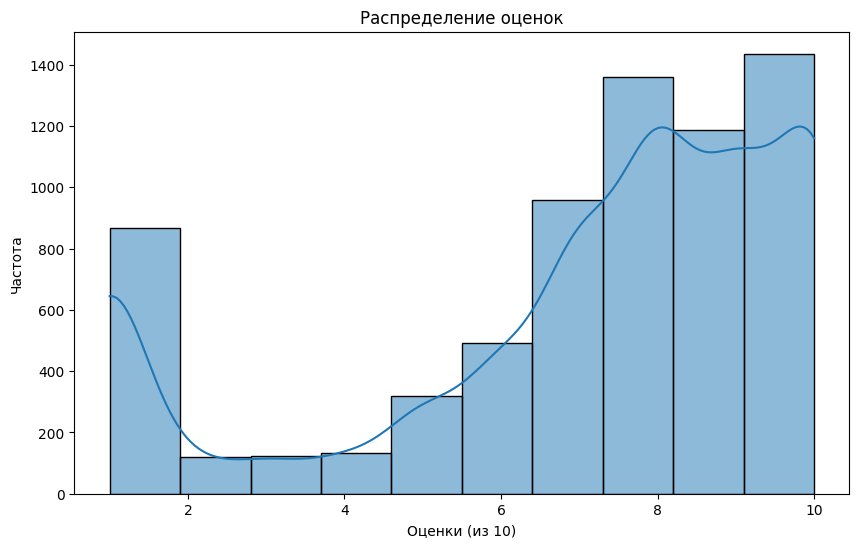

In [103]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Rating(Out of 10)'], bins=10, kde=True)
plt.title('Распределение оценок')
plt.xlabel('Оценки (из 10)')
plt.ylabel('Частота')
plt.show()


<ipython-input-70-1fe56a4f7454>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_ratings = df['Rating(Out of 10)'].resample('M').mean()


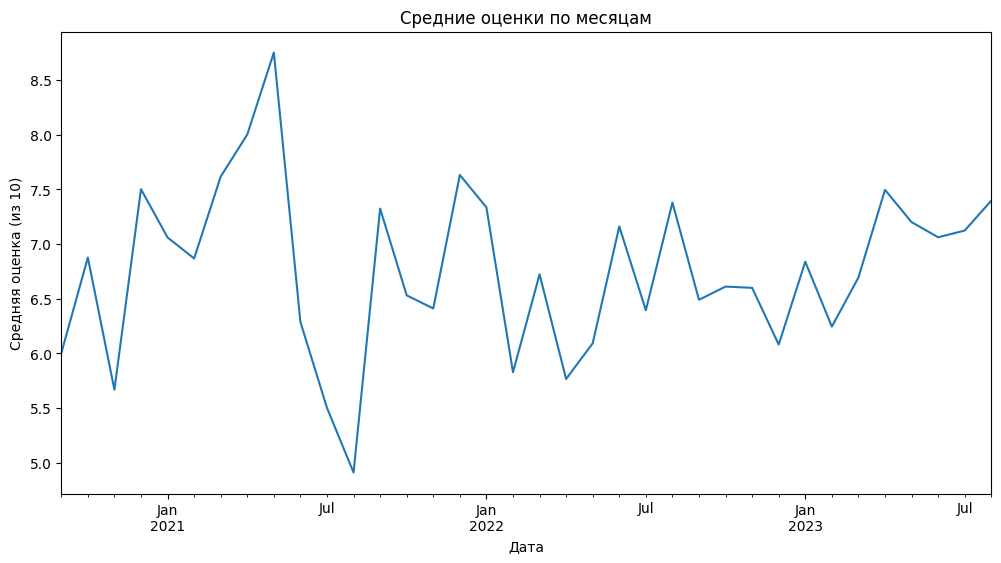

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Преобразование столбца 'Review_Date' в формат datetime
df['Review_Date'] = pd.to_datetime(df['Review_Date'], format='%b-%y')

# Установка 'Review_Date' в качестве индекса
df.set_index('Review_Date', inplace=True)

# Ресэмплинг данных и построение графика средних оценок по месяцам
monthly_avg_ratings = df['Rating(Out of 10)'].resample('M').mean()
monthly_avg_ratings.plot(figsize=(12, 6))
plt.title('Средние оценки по месяцам')
plt.xlabel('Дата')
plt.ylabel('Средняя оценка (из 10)')
plt.show()


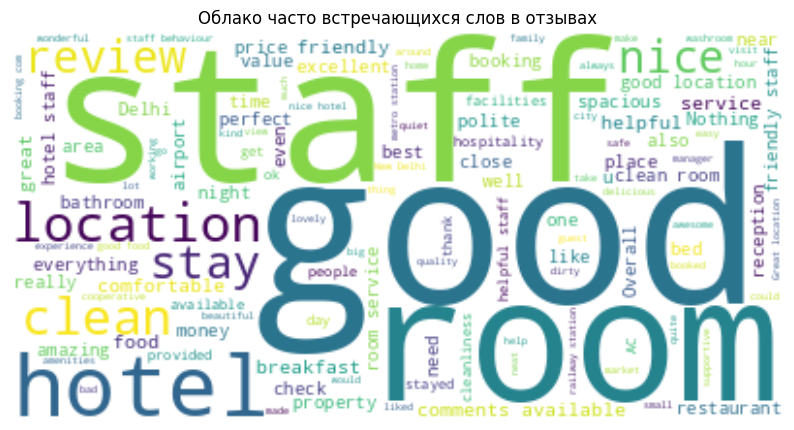

In [75]:
stop_words = set(stopwords.words('english'))

all_reviews = ' '.join(df['Review_Text'])

wordcloud = WordCloud(stopwords=stop_words, background_color='white', max_words=200).generate(all_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако часто встречающихся слов в отзывах')
plt.show()


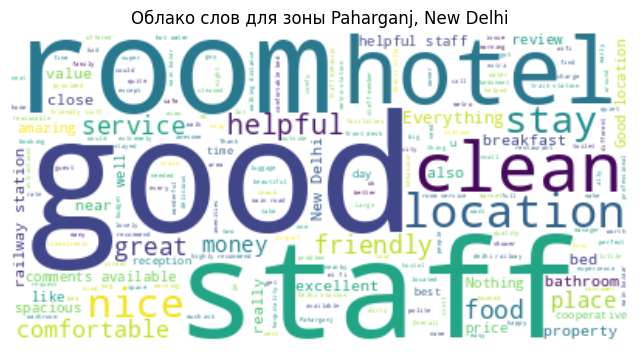

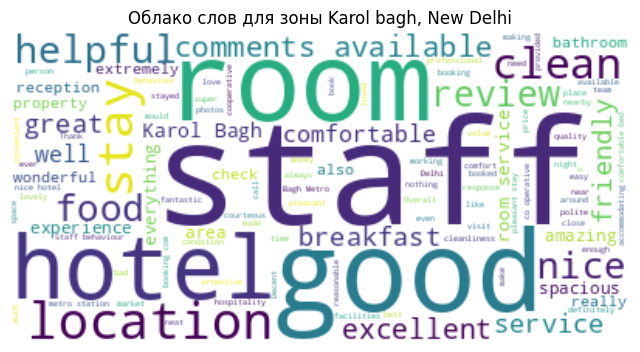

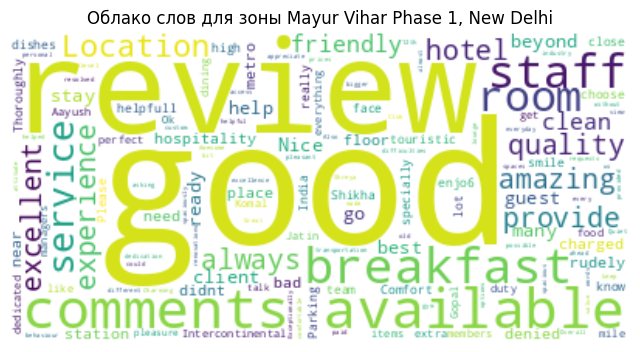

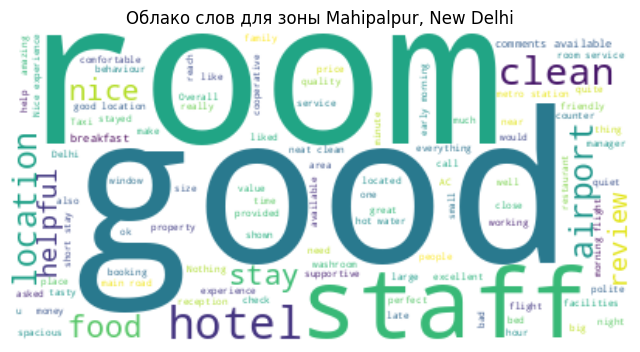

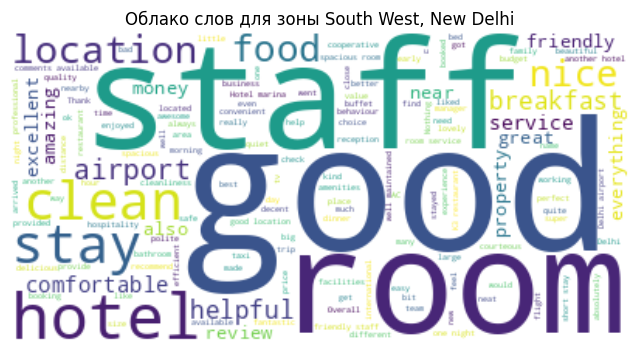

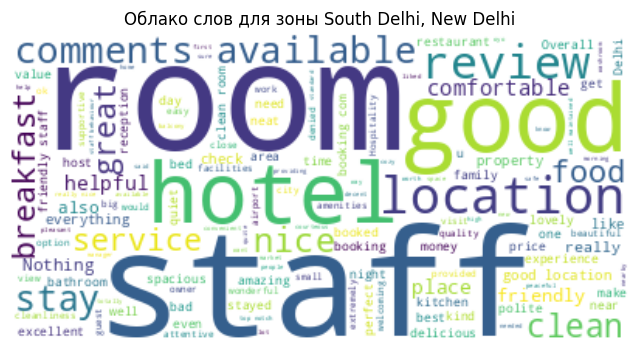

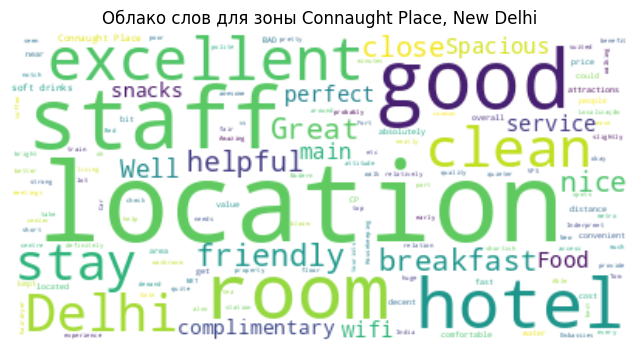

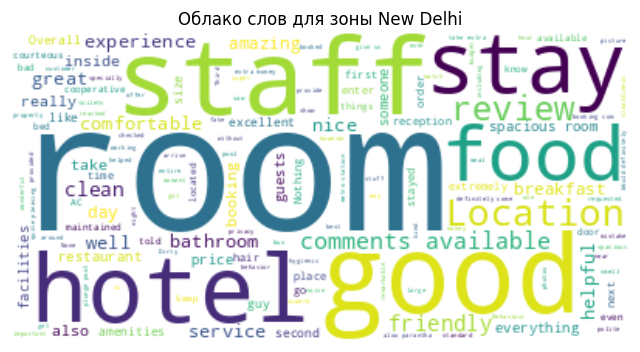

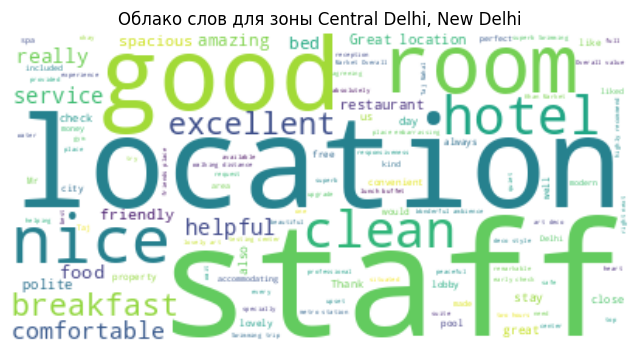

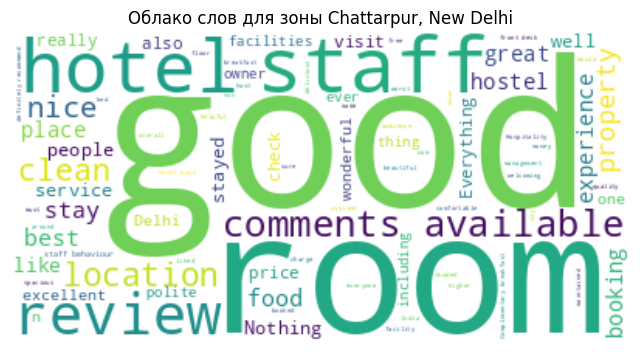

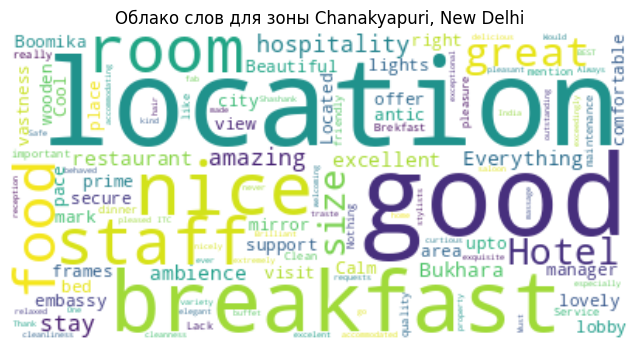

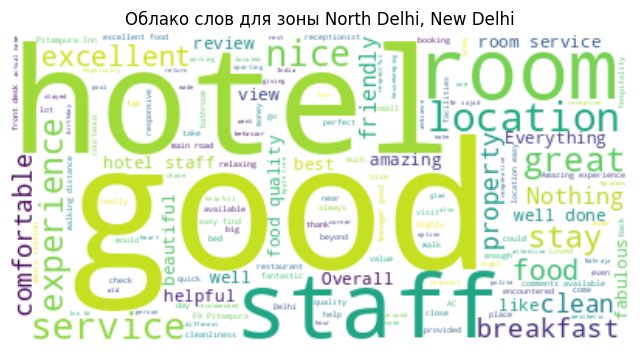

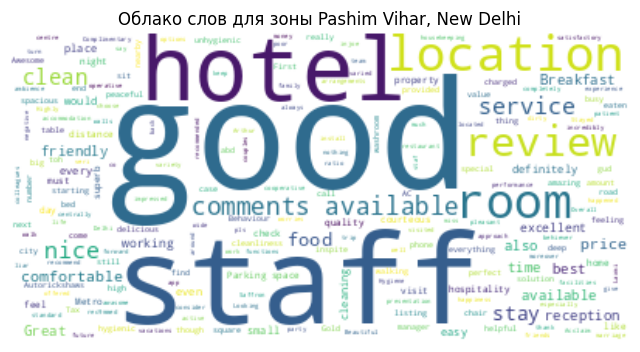

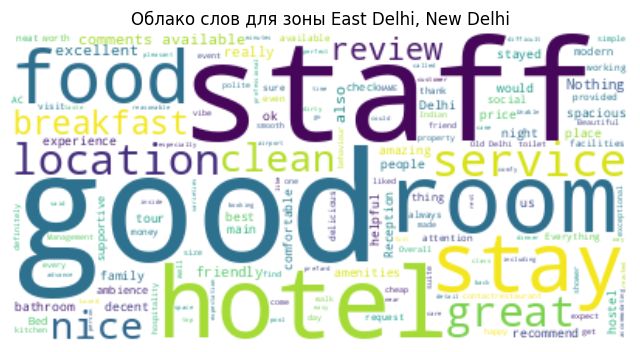

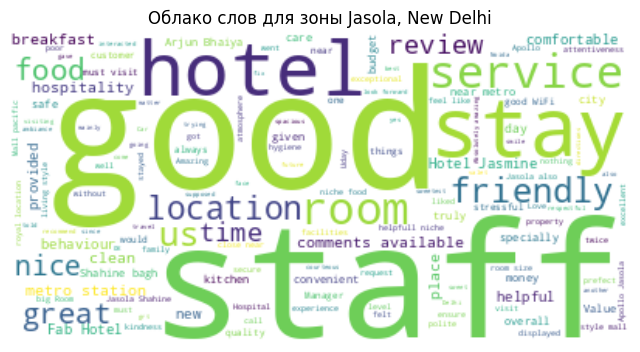

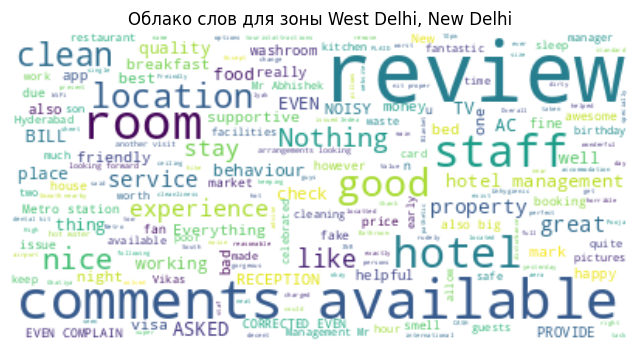

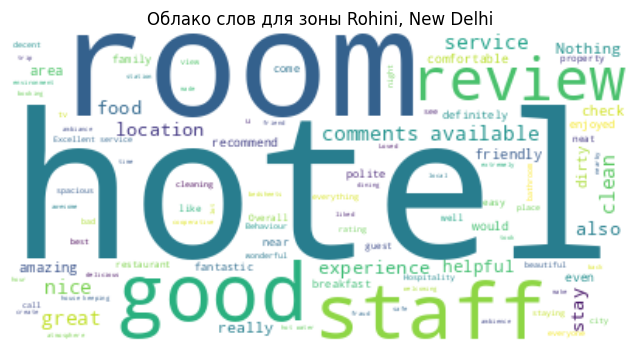

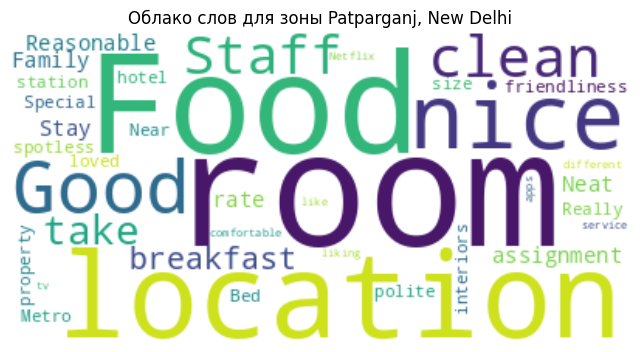

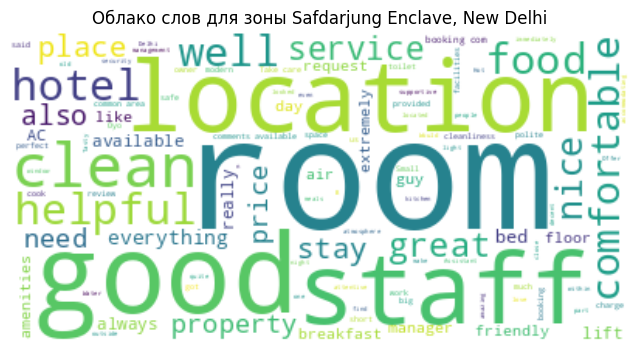

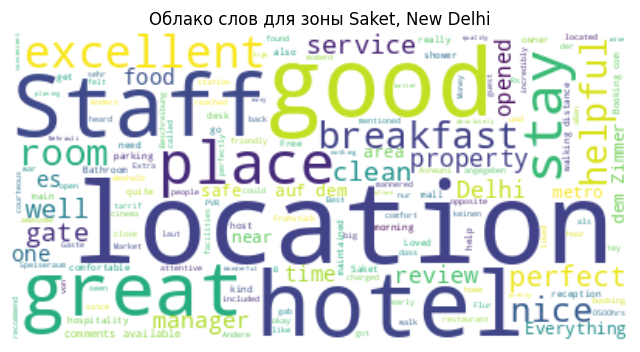

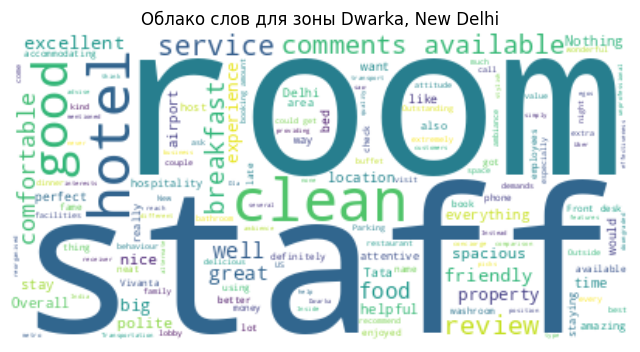

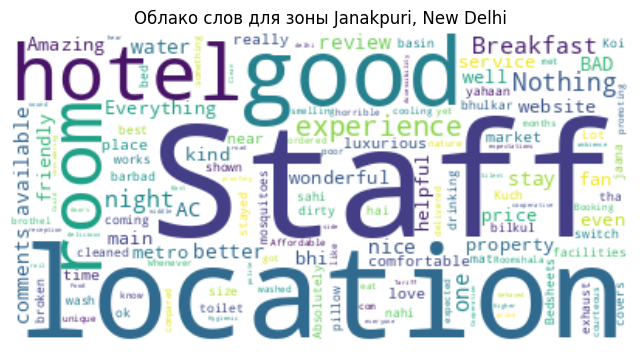

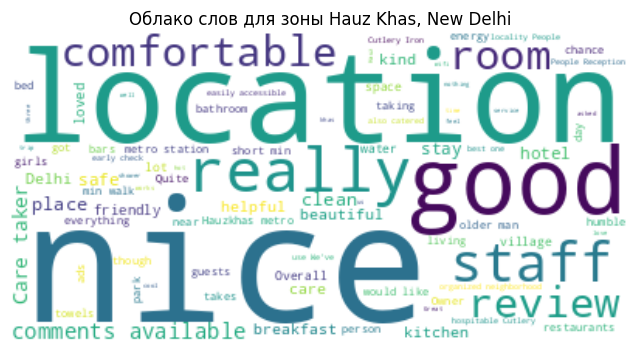

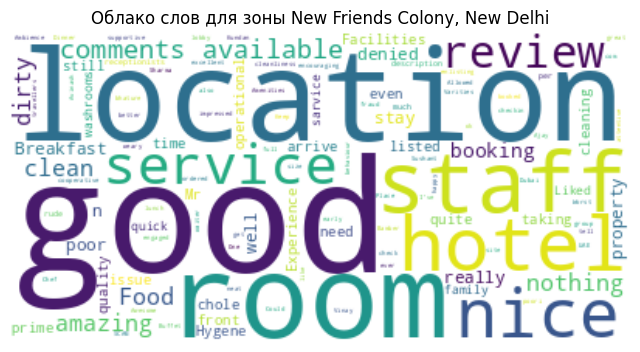

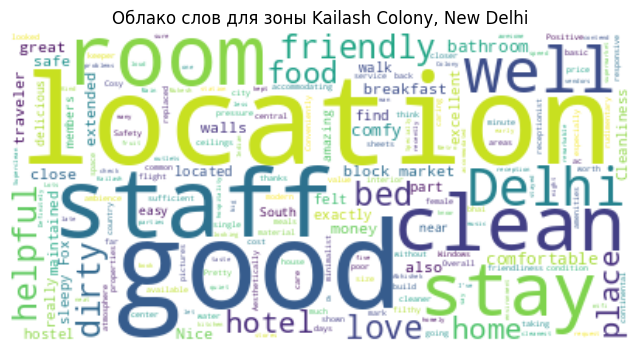

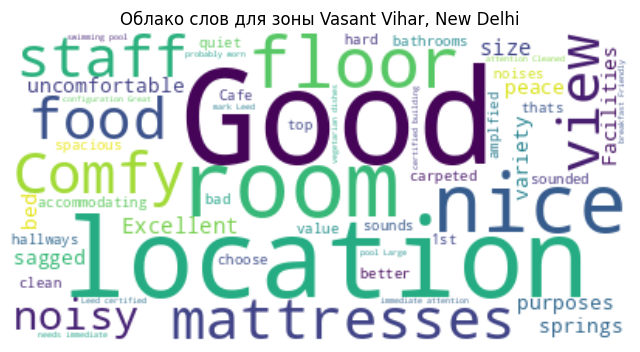

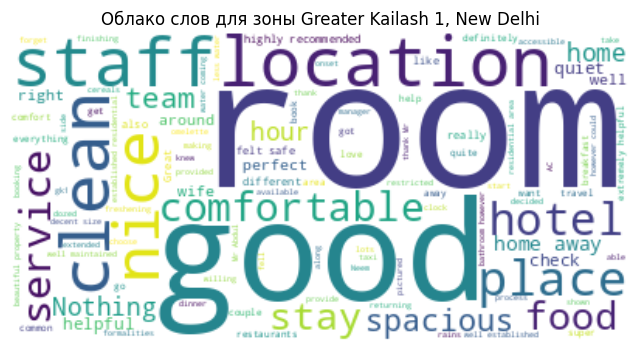

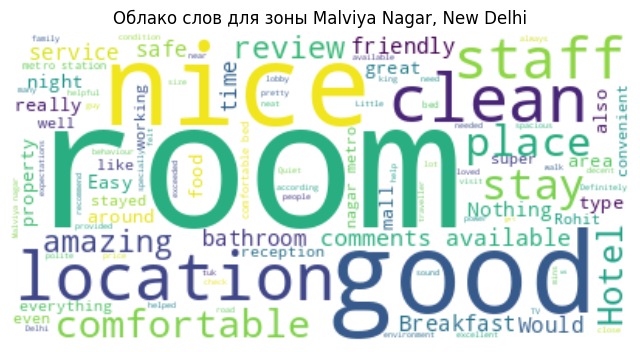

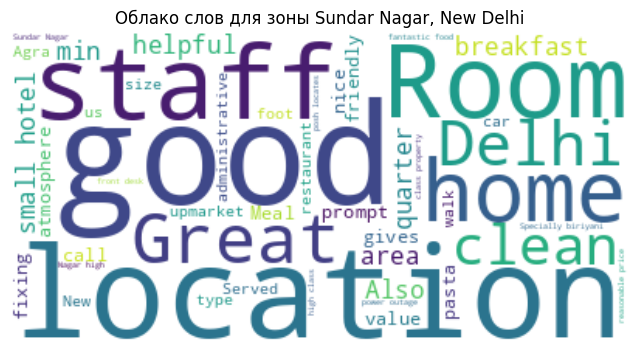

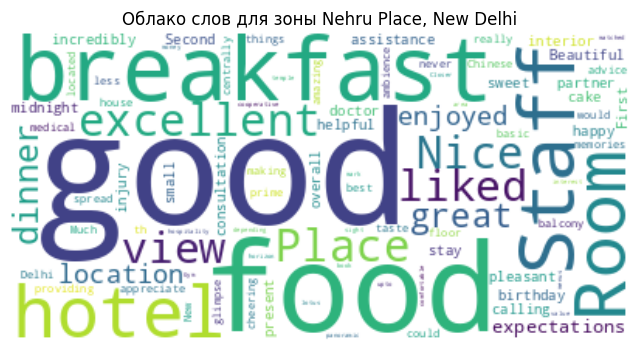

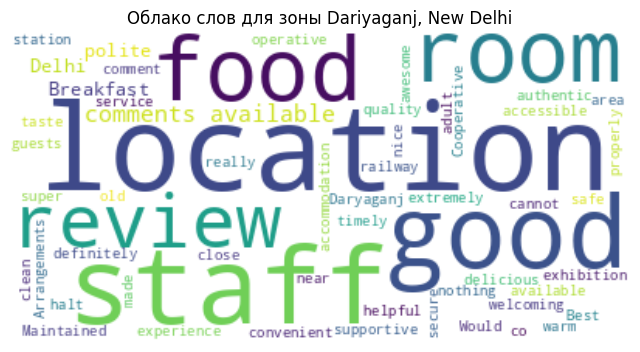

In [86]:
# Функция для создания облака слов по зонам
def create_wordcloud_by_area(area):
    text = ' '.join(df[df['Area'] == area]['Review_Text'])
    wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text)
    plt.figure(figsize=(8, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Облако слов для зоны {area}')
    plt.show()

for area in df['Area'].unique():
    create_wordcloud_by_category(area)


Точно также можно создавать облака слов для каждого отеля по отдельности

## Продвинутый анализ

Используем тематическое моделирование, например, метод LDA (Latent Dirichlet Allocation), чтобы найти основные темы в отзывах.:

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Текст + токенизация
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
tfidf = tfidf_vectorizer.fit_transform(df['Review_Text'])

# LDA моделирование
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf)

# Печать тем
for index, topic in enumerate(lda.components_):
    print(f"Тема {index+1}:")
    print([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Тема 1:
['perfect', 'stay', 'rooms', 'room', 'staff', 'clean', 'hotel', 'like', 'ok', 'location']
Тема 2:
['delhi', 'location', 'good', 'metro', 'bad', 'close', 'airport', 'hotel', 'near', 'station']
Тема 3:
['luxurious', 'fi', 'wi', 'staff', 'money', 'value', 'behaviour', 'review', 'comments', 'available']
Тема 4:
['friendly', 'service', 'stay', 'food', 'great', 'hotel', 'location', 'nice', 'staff', 'good']
Тема 5:
['size', 'location', 'property', 'cleanliness', 'staff', 'bed', 'good', 'comfortable', 'clean', 'room']


### Анализ тем, выявленных методом LDA в отзывах

Метод LDA позволил выделить 5 ключевых тем в отзывах о гостиницах. На основе содержания каждой темы можно сделать следующие выводы:

### Тема 1: Чистота и персонал
- Основные слова: perfect, stay, rooms, room, staff, clean, hotel, like, ok, location
- Анализ: Эта тема сосредоточена на чистоте номеров и работе персонала, а также на общем впечатлении от пребывания в гостинице. Слова "perfect" и "clean" указывают на положительные оценки в отношении чистоты, что является важным критерием для гостей.

### Тема 2: Удобное расположение
- Основные слова: delhi, location, good, metro, bad, close, airport, hotel, near, station
- Анализ: Тематика отражает значимость местоположения гостиницы для гостей. Особое внимание уделяется доступности метро, аэропорта и других объектов, что, вероятно, повышает удобство для путешественников. Слово "bad" может указывать на возможные негативные отзывы об отдельных аспектах расположения.

### Тема 3: Соотношение цены и качества, доступ к Wi-Fi
- Основные слова: luxurious, fi, wi, staff, money, value, behaviour, review, comments, available
- Анализ: Эта тема касается соотношения цены и качества, уровня роскоши, а также доступности Wi-Fi. Слова "value" и "money", предполагают, что гости часто оценивают, насколько услуги оправдывают их стоимость. Доступ к Wi-Fi и поведение персонала также оказываются важными факторами.

### Тема 4: Обслуживание и питание
- Основные слова: friendly, service, stay, food, great, hotel, location, nice, staff, good
- Анализ: Данная тема акцентирует внимание на обслуживании и еде. Слова "friendly" и "service" указывают на значимость дружественного отношения персонала и качественного сервиса для гостей. Положительные оценки касаются как обслуживания, так и питания, что влияет на общее впечатление от пребывания.

### Тема 5: Комфорт и чистота
- Основные слова: size, location, property, cleanliness, staff, bed, good, comfortable, clean, room
- Анализ: Эта тема подчеркивает важность комфорта, размера и чистоты номеров. Особое внимание уделено удобству кровати, что является важным фактором для гостей, ищущих комфортное проживание.

### Общий вывод
Анализ тем позволил выявить что важно для гостей. В дальнейшем мы используем эту информацию для создания промпта.

Теперь давайте выявим часто встречающиеся слова в положительном и негативном наборах слов

In [94]:
from collections import Counter

# Создаем набор всех слов
positive_words = ' '.join(df[df['Rating(Out of 10)'] >= 8]['Review_Text']).split()
negative_words = ' '.join(df[df['Rating(Out of 10)'] <= 5]['Review_Text']).split()

# Посчитаем частоту ключевых слов
positive_keywords = Counter([word for word in positive_words if word \
                             not in stop_words and len(word) > 2]).most_common(10)
negative_keywords = Counter([word for word in negative_words if word \
                             not in stop_words and len(word) > 2]).most_common(10)

print("Положительные ключевые слова:", positive_keywords)
print("Отрицательные ключевые слова:", negative_keywords)


Положительные ключевые слова: [('The', 1483), ('good', 1128), ('staff', 1051), ('hotel', 834), ('room', 720), ('stay', 605), ('location', 522), ('clean', 485), ('nice', 465), ('service', 384)]
Отрицательные ключевые слова: [('available', 295), ('review', 284), ('comments', 282), ('hotel', 237), ('room', 178), ('Nothing', 165), ('The', 161), ('good', 129), ('location', 115), ('staff', 110)]


### Анализ часто встречающихся слов в положительных и негативных отзывах

На основе ключевых слов, часто встречающихся в положительных и негативных отзывах, можно сделать следующие выводы о том, что клиенты считают сильными и слабыми сторонами гостиниц.

### Положительные ключевые слова
- Ключевые слова: good, staff, hotel, room, stay, location, clean, nice, service
- Анализ:
  - Good (1128): Частое использование слова "good" указывает на общее положительное впечатление от различных аспектов гостиниц. Гости просто довольны качеством услуг и условиями проживания.
  - Staff (1051): Персонал - ключевой аспект, который вызывает положительные отзывы. Значит на это можно сделать упор в описании.
  - Hotel (834) и Room (720): Положительные оценки самого отеля и его номеров говорят о том, что клиенты довольны обстановкой, интерьером и комфортом.
  - Stay (605) и Location (522): Гости также высоко оценивают удобство расположения и общее впечатление от пребывания в гостинице.
  - Clean (485) и Nice (465): Чистота и приятная атмосфера также оказывают значительное влияние на позитивные оценки.
  - Service (384): Довольные клиенты часто отмечают качество обслуживания, что указывает на важность поддержания высоких стандартов сервиса.

### Отрицательные ключевые слова
- Ключевые слова: available, review, comments, hotel, room, Nothing, good, location, staff
- Анализ:
  - Available (295): Частое использование слова "available" в негативном контексте может указывать на нехватку или недоступность определенных услуг или удобств, что вызывает разочарование у клиентов.
  - Review (284) и Comments (282): Упоминание этих слов может отражать неудовлетворенность гостей, которая побудила их оставить отзыв или комментарий. Также это может указывать на накрутку или высокое количество отзывов.
  - Hotel (237) и Room (178): Негативные отзывы по этим аспектам могут означать проблемы с состоянием отеля или номеров, такими как неудовлетворительные условия проживания, уровень комфорта или шум.
  - Nothing (165): Слово "Nothing" может указывать на очень негативные отзывы, когда гости не находят ни одного положительного аспекта в своем опыте.
  - Good (129) и Location (115): Даже несмотря на наличие положительного контекста для этих слов, они также встречаются в негативных отзывах, что может отражать неустойчивость качества услуг или расположения.
  - Staff (110): Некоторые клиенты отмечают неудовлетворенность обслуживанием со стороны персонала, что ещё раз подтверждает важность этого аспекта.

### Общий вывод
Часто встречающиеся слова в положительных и негативных отзывах подтверждают, что наибольшее значение для гостей имеют качество обслуживания, персонал, комфорт и чистота номеров, а также удобство расположения. В то же время, недоступность услуг, несоответствие ожиданиям и негативный опыт с персоналом могут привести к разочарованию и отрицательным отзывам.

Гостиницам стоит уделить особое внимание улучшению доступности удобств и повышению качества обслуживания, чтобы минимизировать негативные отзывы.

А нам стоит уделить внимание всем выявленным аспектам, чтобы на их основе генерировать описания.

## Анализ тональности отзывов

Будем использовать модель BERT, дообученную на русскоязычных отзывах.

In [104]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd

In [105]:
# Загружаем токенизатор и модель ruBERT для анализа тональности
tokenizer = AutoTokenizer.from_pretrained("blanchefort/rubert-base-cased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("blanchefort/rubert-base-cased-sentiment")

# Создаём пайплайн для анализа сентимента
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Проанализируем тональность всех отзывов, применив функцию ко всем отзывам в датасете

In [107]:
df2 = df.head(100)

In [111]:
df2['Sentiment'] = df2['Review_Text'].apply(lambda x: sentiment_analyzer(x)[0])

<ipython-input-111-7301c2fc60a1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Sentiment'] = df2['Review_Text'].apply(lambda x: sentiment_analyzer(x)[0])


Теперь давайте предскажем рейтинги отзывов на основе получившихся тональностей отзывов. Сначала вычислим тональность для каждого отзыва (для негативных будем брать `1 - score`, для позитивных `score`, а для нейтральных `0.5`).

In [134]:
df2['Sentiment_Rating'] = df2['Sentiment'].apply(lambda result: sum([1 - result['score'] if result['label'] == "NEGATIVE" else result['score'] * 1.1 if result["label"] == "POSITIVE" else 0.7]) * 10)

<ipython-input-134-c09edf86a18d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Sentiment_Rating'] = df2['Sentiment'].apply(lambda result: sum([1 - result['score'] if result['label'] == "NEGATIVE" else result['score'] * 1.1 if result["label"] == "POSITIVE" else 0.7]) * 10)


In [125]:
df2

Index                                          Name                  Area  \
0       0                               Hotel The Pearl  Paharganj, New Delhi   
1       1                               Hotel The Pearl  Paharganj, New Delhi   
2       2                               Hotel The Pearl  Paharganj, New Delhi   
3       3                               Hotel The Pearl  Paharganj, New Delhi   
4       4                               Hotel The Pearl  Paharganj, New Delhi   
..    ...                                           ...                   ...   
95     95  Trimrooms Shipra @ New Delhi Railway Station  Paharganj, New Delhi   
96     96  Trimrooms Shipra @ New Delhi Railway Station  Paharganj, New Delhi   
97     97  Trimrooms Shipra @ New Delhi Railway Station  Paharganj, New Delhi   
98     98  Trimrooms Shipra @ New Delhi Railway Station  Paharganj, New Delhi   
99     99  Trimrooms Shipra @ New Delhi Railway Station  Paharganj, New Delhi   

   Review_Date                           Rating_attribute  Rating(Out of 10)  \
0       Jul-23                 Best budget friendly hotel                9.0   
1       Aug-23                              Amazing place                9.0   
2       Aug-23               Overall good stay. Economic.                9.0   
3       Aug-23                                     Lovely                9.0   
4       Aug-23  Great hotel Great staff and great staying                9.0   
..         ...                                        ...                ...   
95      Aug-23         Unsatisfied and very disappointed.                1.0   
96      Jun-23                              Disappointing                4.0   
97      Jul-23                                Exceptional               10.0   
98      Jun-23                                Exceptional               10.0   
99      Jun-23                                Exceptional               10.0   

                                          Review_Text  \
0   Hotel the pearl is perfect place to stay in De...   
1   Location of the hotel is perfect. The hotel is...   
2                              Location, Indian food.   
3   The location and the hotel itself is great. Ne...   
4   Friendly and smiling staffs.. The reception st...   
..                                                ...   
95                                           Nothing.   
96                        Location was center of city   
97  The staff was good and also was in a prime loc...   
98                    Great service and helpful staff   
99  Nice location good food neat nd clean room nea...   

                                            Sentiment  Sentiment_Rating  
0   {'label': 'POSITIVE', 'score': 0.8580577969551...          8.580578  
1   {'label': 'POSITIVE', 'score': 0.9811563491821...          9.811563  
2   {'label': 'NEUTRAL', 'score': 0.8295720219612122}          6.881897  
3   {'label': 'NEUTRAL', 'score': 0.6511367559432983}          4.239791  
4   {'label': 'POSITIVE', 'score': 0.9536622762680...          9.536623  
..                                                ...               ...  
95  {'label': 'NEUTRAL', 'score': 0.8051691651344299}          6.482974  
96  {'label': 'NEUTRAL', 'score': 0.8218796253204346}          6.754861  
97  {'label': 'NEUTRAL', 'score': 0.4931369125843048}          2.431840  
98  {'label': 'NEGATIVE', 'score': 0.7514938116073...          2.485062  
99  {'label': 'NEUTRAL', 'score': 0.5899295806884766}          3.480169  

[100 rows x 9 columns]

Напишем функцию для предсказания рейтинга отеля на основе Sentiment_Rating, получаемых при анализе тональности каждого отзыва. Будем брать среднее арифметическое от этих оценок.

In [128]:
def predict_hotel_rating(df, hotel_name):
  hotel_reviews = df[df['Name'] == hotel_name]

  return hotel_reviews['Sentiment_Rating'].mean()

Также напишем функцию для подсчета средней оценки по реальным оценкам пользователей

In [131]:
def mean_hotel_rating(df, hotel_name):
  hotel_reviews = df[df['Name'] == hotel_name]

  return hotel_reviews['Rating(Out of 10)'].mean()

Сравним

In [130]:
predict_hotel_rating(df2, "Hotel The Pearl")

9.0854971408844

In [132]:
mean_hotel_rating(df2, "Hotel The Pearl")

8.9

In [144]:
print("Сравнение предсказанных и реальных оценок отелей.\n")

for name in df2['Name'].unique():
  print(f"Отель:                 {name}\nРеальный рейтинг:      {mean_hotel_rating(df2, name)}\nПредсказанный рейтинг: {predict_hotel_rating(df2, name)}\n")

Сравнение предсказанных и реальных оценок отелей.

Отель:                 Hotel The Pearl
Реальный рейтинг:      8.9
Предсказанный рейтинг: 9.765267199277877

Отель:                 Hotel Grand Park Inn
Реальный рейтинг:      7.8
Предсказанный рейтинг: 6.274358379840851

Отель:                 FabHotel White Klove Paharganj
Реальный рейтинг:      7.9
Предсказанный рейтинг: 7.9498956322669985

Отель:                 Hotel Mannat international by Mannat
Реальный рейтинг:      8.5
Предсказанный рейтинг: 5.856572562456131

Отель:                 Holiday Inn New Delhi Mayur Vihar Noida, an IHG Hotel
Реальный рейтинг:      8.4
Предсказанный рейтинг: 6.402662366628647

Отель:                 Airport Hotel Grand, New Delhi
Реальный рейтинг:      8.9
Предсказанный рейтинг: 7.59628210067749

Отель:                 Novotel New Delhi Aerocity- International Airport
Реальный рейтинг:      8.2
Предсказанный рейтинг: 5.109551292657852

Отель:                 FabHotel Majestic JPM I
Реальный рейтинг: 

Можем также попробовать другой метод подсчета рейтинга.

In [156]:
df2['Sentiment_Rating_2'] = df2['Sentiment'].apply(lambda result: sum([1 if result['label'] == "NEGATIVE" else 10 if result["label"] == "POSITIVE" else 7]))

<ipython-input-156-04502d69eff9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Sentiment_Rating_2'] = df2['Sentiment'].apply(lambda result: sum([1 if result['label'] == "NEGATIVE" else 10 if result["label"] == "POSITIVE" else 7]))


In [157]:
def predict_hotel_rating_2(df, hotel_name):
  hotel_reviews = df[df['Name'] == hotel_name]

  return hotel_reviews['Sentiment_Rating_2'].mean()

In [158]:
print("Сравнение предсказанных и реальных оценок отелей.\n")

for name in df2['Name'].unique():
  print(f"Отель:                   {name}\nРеальный рейтинг:        {mean_hotel_rating(df2, name)}\nПредсказанный рейтинг 1: {round(predict_hotel_rating(df2, name), 2)}\nПредсказанный рейтинг 2: {predict_hotel_rating_2(df2, name)}\n")

Сравнение предсказанных и реальных оценок отелей.

Отель:                   Hotel The Pearl
Реальный рейтинг:        8.9
Предсказанный рейтинг 1: 9.77
Предсказанный рейтинг 2: 9.4

Отель:                   Hotel Grand Park Inn
Реальный рейтинг:        7.8
Предсказанный рейтинг 1: 6.27
Предсказанный рейтинг 2: 5.5

Отель:                   FabHotel White Klove Paharganj
Реальный рейтинг:        7.9
Предсказанный рейтинг 1: 7.95
Предсказанный рейтинг 2: 7.6

Отель:                   Hotel Mannat international by Mannat
Реальный рейтинг:        8.5
Предсказанный рейтинг 1: 5.86
Предсказанный рейтинг 2: 5.5

Отель:                   Holiday Inn New Delhi Mayur Vihar Noida, an IHG Hotel
Реальный рейтинг:        8.4
Предсказанный рейтинг 1: 6.4
Предсказанный рейтинг 2: 7.0

Отель:                   Airport Hotel Grand, New Delhi
Реальный рейтинг:        8.9
Предсказанный рейтинг 1: 7.6
Предсказанный рейтинг 2: 7.0

Отель:                   Novotel New Delhi Aerocity- International Airport
Ре

### Анализ сравнения предсказанных и реальных оценок отелей


Данные показывают расхождения между реальными и предсказанными рейтингами для различных отелей. Рассмотрим каждый случай, чтобы понять общие тенденции и сделать выводы.

| Отель                                                       | Реальный рейтинг | Предсказанный рейтинг | Отклонение |
|-------------------------------------------------------------|------------------|-----------------------|------------|
| Hotel The Pearl                                             | 8.9             | 9.77                  | +0.87      |
| Hotel Grand Park Inn                                        | 7.8             | 6.27                  | -1.53      |
| FabHotel White Klove Paharganj                              | 7.9             | 7.95                  | +0.05      |
| Hotel Mannat international by Mannat                        | 8.5             | 5.86                  | -2.64      |
| Holiday Inn New Delhi Mayur Vihar Noida, an IHG Hotel       | 8.4             | 6.40                  | -2.00      |
| Airport Hotel Grand, New Delhi                              | 8.9             | 7.60                  | -1.30      |
| Novotel New Delhi Aerocity- International Airport           | 8.2             | 5.11                  | -3.09      |
| FabHotel Majestic JPM I                                     | 8.7             | 7.08                  | -1.62      |
| Airport Hotel Clayton                                       | 8.7             | 5.91                  | -2.79      |
| Trimrooms Shipra @ New Delhi Railway Station                | 7.9             | 5.10                  | -2.80      |

### Выводы

1. Недооценка рейтинга:
   - В большинстве случаев (8 из 10) предсказанная моделью оценка ниже реальной. Это может указывать на наличие систематической недооценки, когда модель чаще занижает рейтинг отелей.
   - Наибольшее отклонение наблюдается у отелей Novotel New Delhi Aerocity- International Airport и Trimrooms Shipra @ New Delhi Railway Station, где предсказания отклонились от реального значения на -3.09 и -2.80 соответственно.

2. Переоценка рейтинга:
   - Модель завышает рейтинг лишь для одного отеля: Hotel The Pearl, где разница составила +0.87. Это меньшая ошибка по сравнению с недооценкой, но также показывает, что модель имеет тенденцию переоценивать определенные отели.

3. Наиболее точное предсказание:
   - Для FabHotel White Klove Paharganj модель смогла предсказать рейтинг с минимальной разницей (+0.05), что указывает на наличие точных данных или более удачное моделирование факторов для этого отеля.

### Общий вывод

В целом, модель нуждается в улучшении, чтобы уменьшить отклонение от реальных значений, особенно в сторону недооценки. Это может быть связано как с неправильной оценкой тональности, так и с неточной функцией подсчёта рейтинга.

### Как улучшить?
Можно использовать более продвинутые способы определения тональности. Например, можно использовать модель Span-ASTE для выявления триплетов (тональность, аспект, объект) и их анализа.

Можно попробовать использовать улучшенную версию модели BERT - roBERTa, дообученную для задачи Sentiment Analysis.

Также можно использовать LLM, но на это уйдёт гораздо больше ресурсов.

Причём в большинстве случаев первый метод работает лучше так как он учитывает `score`

# Второй датасет

В целом, всё самое интересное уже было в первом датасете, но можно посмотреть и этот.

## Сбор данных

In [27]:
import kagglehub

path = kagglehub.dataset_download("jiashenliu/515k-hotel-reviews-data-in-europe")

print(path)

/root/.cache/kagglehub/datasets/jiashenliu/515k-hotel-reviews-data-in-europe/versions/1


In [28]:
dataset_path = path

files = os.listdir(path)

csv_files = [file for file in files if file.endswith('.csv')]

if csv_files:
    csv_file_path = os.path.join(path, csv_files[0])
    df = pd.read_csv(csv_file_path)

    print(df.head())
else:
    print("CSV файл не найден в указанном пути.")


                                       Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
1                           194    8/3/2017            7.7  Hotel Arena   
2                           194   7/31/2017            7.7  Hotel Arena   
3                           194   7/31/2017            7.7  Hotel Arena   
4                           194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1             Ireland                                     

## Анализ датасета

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

In [29]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

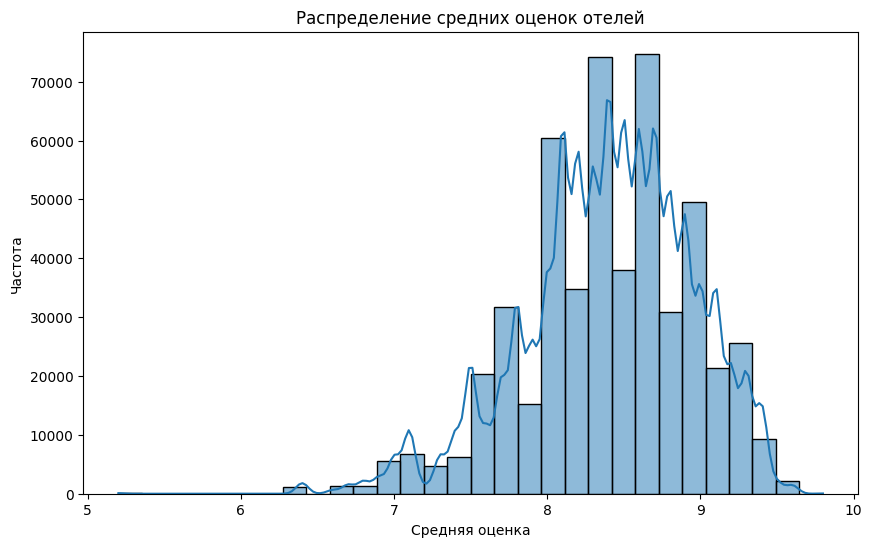

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Average_Score'], bins=30, kde=True)
plt.title('Распределение средних оценок отелей')
plt.xlabel('Средняя оценка')
plt.ylabel('Частота')
plt.show()

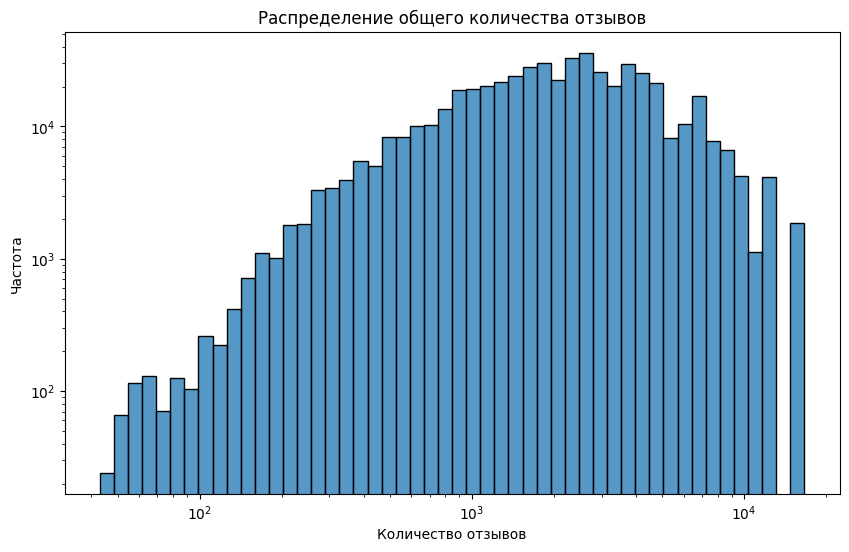

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Total_Number_of_Reviews'], bins=50, log_scale=True)
plt.title('Распределение общего количества отзывов')
plt.xlabel('Количество отзывов')
plt.ylabel('Частота')
plt.yscale('log')  # выводится на логарифмической шкале для лучшей видимости
plt.show()

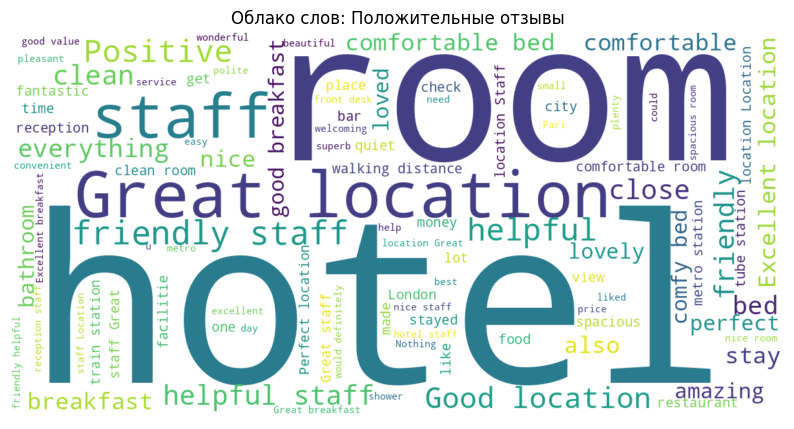

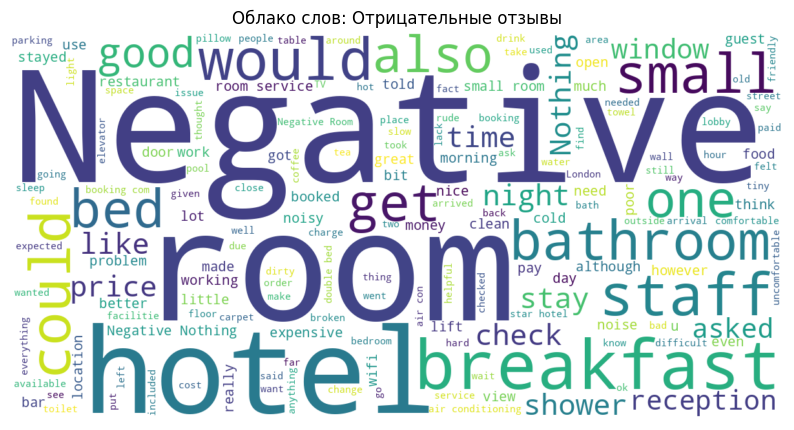

In [32]:
stop_words = set(stopwords.words('english'))

# Объединение всех текстов в одну строку
all_positive_reviews = ' '.join(df['Positive_Review'])
all_negative_reviews = ' '.join(df['Negative_Review'])

def plot_wordcloud(text, title=None):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white', max_words=200, scale=3).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

plot_wordcloud(all_positive_reviews, title='Облако слов: Положительные отзывы')
plot_wordcloud(all_negative_reviews, title='Облако слов: Отрицательные отзывы')


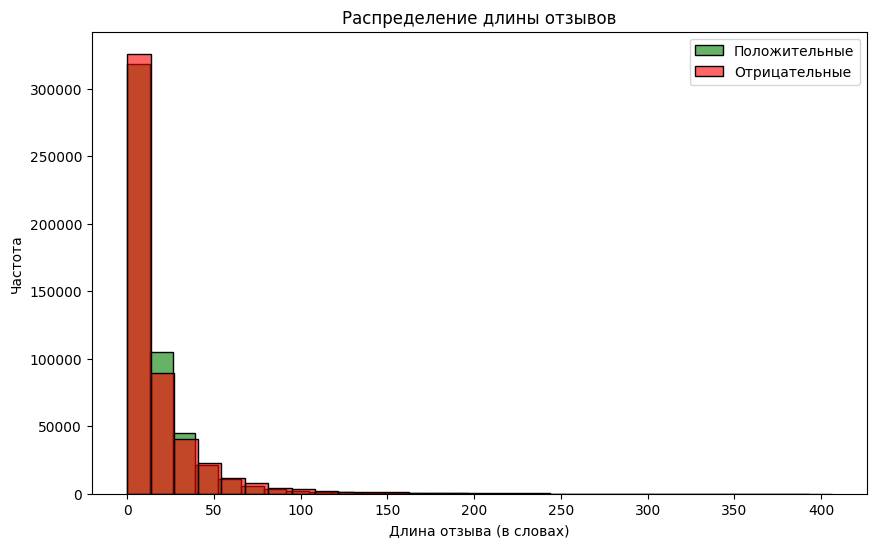

In [33]:
df['Positive_Length'] = df['Positive_Review'].apply(lambda x: len(x.split()))
df['Negative_Length'] = df['Negative_Review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['Positive_Length'], bins=30, color='green', alpha=0.6, label='Положительные')
sns.histplot(df['Negative_Length'], bins=30, color='red', alpha=0.6, label='Отрицательные')
plt.title('Распределение длины отзывов')
plt.xlabel('Длина отзыва (в словах)')
plt.ylabel('Частота')
plt.legend()
plt.show()


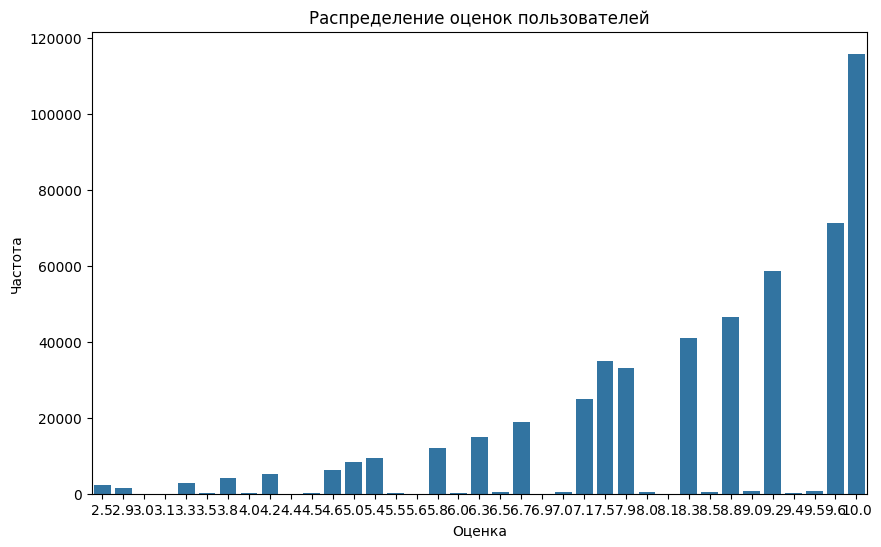

In [34]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df['Reviewer_Score'])
plt.title('Распределение оценок пользователей')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.show()


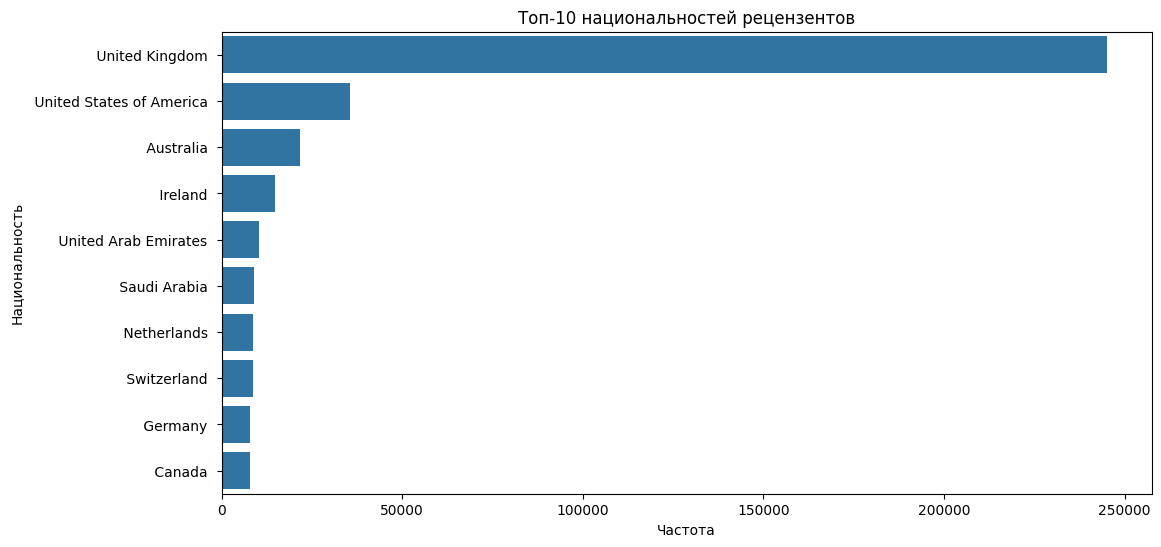

In [35]:
# В датасете есть прикольная колонка, почему бы её не использовать?
plt.figure(figsize=(12, 6))
sns.countplot(y=df['Reviewer_Nationality'], order=df['Reviewer_Nationality'].value_counts().index[:10])
plt.title('Топ-10 национальностей рецензентов')
plt.xlabel('Частота')
plt.ylabel('Национальность')
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Текст + токенизация
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
tfidf = tfidf_vectorizer.fit_transform(df['allText'])

# LDA моделирование
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf)

# Печать тем
for index, topic in enumerate(lda.components_):
    print(f"Тема {index+1}:")
    print([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
